# Uber Vs Lyft - Which Service Is Better?

### Understanding the quality of Rideshare Apps, Uber & Lyft, based on factors such as distance traveled, pricing and weather conditions in Winter 2018, Boston (MA)

In [1]:
# Importing dependencies required for our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scipy.stats as st
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Referencing our csv files to prep for merging
cab_ride_df = pd.read_csv("Cab-Weather-Data/cab_rides.csv")
weather_df = pd.read_csv("Cab-Weather-Data/weather.csv")
 

## Part 1 - Cleaning our data
----
#### Our Cab Ride data contains a list of rides taken between a range of sources and destinations, along with their prices, surge multipliers and ride type (example - Uber Pool or Uber XL). Our Weather data gives us a selection of weather conditions measure against a series of similar timestamps.

In [3]:
# Cleaning Weather Data
# The timestamps are listed in epoch formatting, and needs to be converted to a readable date format

weather_df["date"] = pd.to_datetime(weather_df["time_stamp"], unit="s")

# Reorder the columns for readability
clean_weather_df = weather_df[["date","location","temp","clouds","pressure","rain","humidity","wind"]]


# Reset the index and change the location header to source. This is so our merge will align on common time point & weather conditions at pick up location
new_weather_df = clean_weather_df.reset_index(drop=True)
new_weather_df.rename(columns={"location":"source"}, inplace=True)
new_weather_df.head()

,date,source,temp,clouds,pressure,rain,humidity,wind
0,2018-12-16 23:45:01,Back Bay,42.42,1.0,1012.14,0.1228,0.77,11.25
1,2018-12-16 23:45:01,Beacon Hill,42.43,1.0,1012.15,0.1846,0.76,11.32
2,2018-12-16 23:45:01,Boston University,42.50,1.0,1012.15,0.1089,0.76,11.07
3,2018-12-16 23:45:01,Fenway,42.11,1.0,1012.13,0.0969,0.77,11.09
4,2018-12-16 23:45:01,Financial District,43.13,1.0,1012.14,0.1786,0.75,11.49


In [4]:
# Cleaning Car Ride Data
# The epoch timestamp in this table is represented in milliseconds, so we divide by 1000 to find the time in value of seconds
cab_ride_df["date"]=pd.to_datetime(cab_ride_df["time_stamp"]/1000, unit="s")

# Removing unwanted columns like id and product_id
clean_cab_df = cab_ride_df[["date","source","destination","distance","price","surge_multiplier","cab_type", "name"]]

# Resetting the index
new_cab_df=clean_cab_df.reset_index(drop=True)
new_cab_df.head()


,date,source,destination,distance,price,surge_multiplier,cab_type,name
0,2018-12-16 09:30:07.890000128,Haymarket Square,North Station,0.44,5.0,1.0,Lyft,Shared
1,2018-11-27 02:00:23.676999936,Haymarket Square,North Station,0.44,11.0,1.0,Lyft,Lux
2,2018-11-28 01:00:22.197999872,Haymarket Square,North Station,0.44,7.0,1.0,Lyft,Lyft
3,2018-11-30 04:53:02.749000192,Haymarket Square,North Station,0.44,26.0,1.0,Lyft,Lux Black XL
4,2018-11-29 03:49:20.223000064,Haymarket Square,North Station,0.44,9.0,1.0,Lyft,Lyft XL


In [5]:
# Merge the datesets into a single one based on time_stamp and location
# Our timestamps vary across our weather and car ride data, so on rows where we don't have an exact match, we want to merge weather conditions at an approximated timestamp of 15 minutes
cleaned_merged_df = pd.merge_asof(new_cab_df.sort_values("date"), new_weather_df.sort_values("date"), 
                            left_by=  ['source' ],right_by= ['source' ] ,
                            left_on=  ['date']   ,right_on= ['date'], tolerance=pd.Timedelta(minutes = 15 ))
cleaned_merged_df.head()



,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,NaN,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,NaN,1.0,Uber,Taxi,40.80,0.87,1014.39,NaN,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,NaN,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,NaN,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,NaN,0.93,1.36


In [6]:
# Taking a look at our cleaned and merged dataframe as a whole to identify any obvious data points
cleaned_merged_df.describe


<bound method NDFrame.describe of                                 date                   source  \
0      2018-11-26 03:40:46.318000128        Boston University   
1      2018-11-26 03:40:46.319000064         Theatre District   
2      2018-11-26 03:40:46.319000064            South Station   
3      2018-11-26 03:40:46.320000000         Theatre District   
4      2018-11-26 03:40:46.320000000  Northeastern University   
...                              ...                      ...   
693066 2018-12-18 19:15:10.943000064  Northeastern University   
693067 2018-12-18 19:15:10.943000064              Beacon Hill   
693068 2018-12-18 19:15:10.943000064  Northeastern University   
693069 2018-12-18 19:15:10.943000064  Northeastern University   
693070 2018-12-18 19:15:10.943000064  Northeastern University   

             destination  distance  price  surge_multiplier cab_type  \
0       Theatre District      3.03   34.0               1.0     Lyft   
1              North End      1.57    NaN

In [7]:
# To ensure we have all rows that have weather conditions present, we want to drop all null values in the Temperature column
# Null values for rain or wind is ok because these are logical weather conditions
final_df=cleaned_merged_df.dropna(subset=["temp"])
final_df=final_df.reset_index(drop=True)

# With the null values in other rows, we can fill them with "0"
final_df.fillna(0,inplace=True)
final_df.head()

,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36


In [8]:
# Adding the day of the week and month to our table to see if that may have any correlation to weather or pricing
final_df["day_of_week"]=final_df["date"].dt.day_name()

final_df["month"] = final_df["date"].dt.month

final_df.head()


,date,source,destination,distance,price,surge_multiplier,cab_type,name,temp,clouds,pressure,rain,humidity,wind,day_of_week,month
0,2018-11-26 03:40:46.318000128,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,0.86,1014.39,0.0,0.92,1.36,Monday,11
1,2018-11-26 03:40:46.319000064,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
2,2018-11-26 03:40:46.319000064,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,0.87,1014.39,0.0,0.93,1.60,Monday,11
3,2018-11-26 03:40:46.320000000,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,0.87,1014.39,0.0,0.93,1.55,Monday,11
4,2018-11-26 03:40:46.320000000,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,0.89,1014.35,0.0,0.93,1.36,Monday,11


In [9]:
# Formatting some columns to show accurate values for percentages

final_df["clouds"]=final_df["clouds"]*100
final_df["humidity"]=final_df["humidity"]*100


In [10]:
# Pretty-fying our final dataframe by including units of measurement for easy analysis

final_df = final_df.rename(columns={"date":"Date","day_of_week":"Weekday", "month":"Month","source":"Pick_Up_Location","destination":"Destination",
                                    "distance":"Distance(m)","price":"Price($)","surge_multiplier":"Surge_Multiplier",
                                    "cab_type":"Rideshare_App","name":"Ride_Type","temp":"Temp(C)",
                                    "clouds":"Cloudiness(%)","pressure":"Pressure(MB)","rain":"Rainfall(in)",
                                    "humidity":"Humidity(%)","wind":"Wind_Speed(mph)"})

final_df = final_df[["Date","Weekday","Month","Pick_Up_Location","Destination","Distance(m)","Price($)","Surge_Multiplier","Rideshare_App","Ride_Type",
                     "Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)"]]
final_df.head()

,Date,Weekday,Month,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph)
0,2018-11-26 03:40:46.318000128,Monday,11,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36
1,2018-11-26 03:40:46.319000064,Monday,11,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55
2,2018-11-26 03:40:46.319000064,Monday,11,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60
3,2018-11-26 03:40:46.320000000,Monday,11,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55
4,2018-11-26 03:40:46.320000000,Monday,11,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36


In [11]:
# Finding the size of our final dataframe
final_df.shape

(251827, 16)

In [12]:
# Save the dataframe into a csv file to analyze further
final_df.to_csv("rideshare_vs_weather.csv", index=False)

## Part 2 - General Behavior of Car Ride Frequency
----
#### With a large set of data, we want to begin by understanding the general marketability of Uber vs Lyft, like what's the general preference of rides or who makes more money. This is our first step before diving into more deeper analyses

2.A. What is the overall percentages of rides taken over the given timeframe?

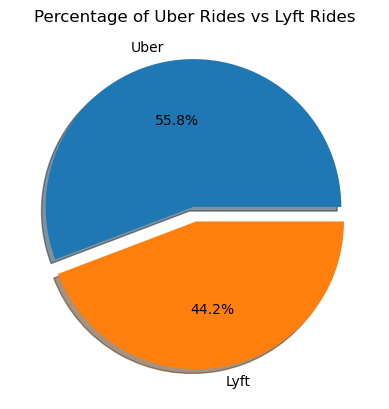

In [13]:
# Pie chart created to see the percentage of lyft rides to Uber Rides
ride_counts = final_df["Rideshare_App"].value_counts()
percentages = (ride_counts / ride_counts.sum()) * 100

explode = [0.05] * len(percentages)

plt.pie(percentages, labels=percentages.index, explode=explode, shadow=True, autopct='%1.1f%%')
plt.title('Percentage of Uber Rides vs Lyft Rides') 
plt.savefig("Images/2_1.png")
plt.show()

2.B How many rides were taken depending on distance travelled? Do people use Lyft or Uber more for longer distances?

In [14]:
# Find the min and max distance of the trips to find the ranges 

maximum_distance = final_df["Distance(m)"].max()
minimum_distance = final_df["Distance(m)"].min()

print("Maximum Distance:", maximum_distance)
print("Minimum Distance:", minimum_distance)

Maximum Distance: 7.5
Minimum Distance: 0.02


In [15]:
# Filter the DataFrame to include only Uber rides
uber_rides = final_df[final_df["Rideshare_App"] == "Uber"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Uber rides within each distance range
ride_counts = [
    ((uber_rides["Distance(m)"] >= 0) & (uber_rides["Distance(m)"] <= 2)).sum(),
    ((uber_rides["Distance(m)"] > 2) & (uber_rides["Distance(m)"] <= 4)).sum(),
    ((uber_rides["Distance(m)"] > 4) & (uber_rides["Distance(m)"] <= 6)).sum(),
    ((uber_rides["Distance(m)"] > 6) & (uber_rides["Distance(m)"] <= 8)).sum()
]

# Isolate this info into a dataframe
uber_ranges = pd.DataFrame({"Distance Range":distance_ranges,"Uber Ride Count":ride_counts})
uber_ranges

,Distance Range,Uber Ride Count
0,0-2 miles,67317
1,2-4 miles,63131
2,4-6 miles,8679
3,6-8 miles,1339


In [16]:
# Filter the DataFrame to include only Lyft rides
lyft_rides = final_df[final_df["Rideshare_App"] == "Lyft"]

# Define the distance ranges
distance_ranges = ["0-2 miles", "2-4 miles", "4-6 miles", "6-8 miles"]

# Count the number of Lyft rides within each distance range
ride_counts = [
    ((lyft_rides["Distance(m)"] >= 0) & (lyft_rides["Distance(m)"] <= 2)).sum(),
    ((lyft_rides["Distance(m)"] > 2) & (lyft_rides["Distance(m)"] <= 4)).sum(),
    ((lyft_rides["Distance(m)"] > 4) & (lyft_rides["Distance(m)"] <= 6)).sum(),
    ((lyft_rides["Distance(m)"] > 6) & (lyft_rides["Distance(m)"] <= 8)).sum()
]

# Isolate this info into a dataframe
lyft_ranges = pd.DataFrame({"Distance Range":distance_ranges,"Lyft Ride Count":ride_counts})
lyft_ranges

,Distance Range,Lyft Ride Count
0,0-2 miles,51883
1,2-4 miles,51591
2,4-6 miles,7865
3,6-8 miles,22


In [17]:
# Merge data into a single table for easy plotting
range_df=pd.merge(uber_ranges,lyft_ranges, on="Distance Range", how="left")
range_df

,Distance Range,Uber Ride Count,Lyft Ride Count
0,0-2 miles,67317,51883
1,2-4 miles,63131,51591
2,4-6 miles,8679,7865
3,6-8 miles,1339,22


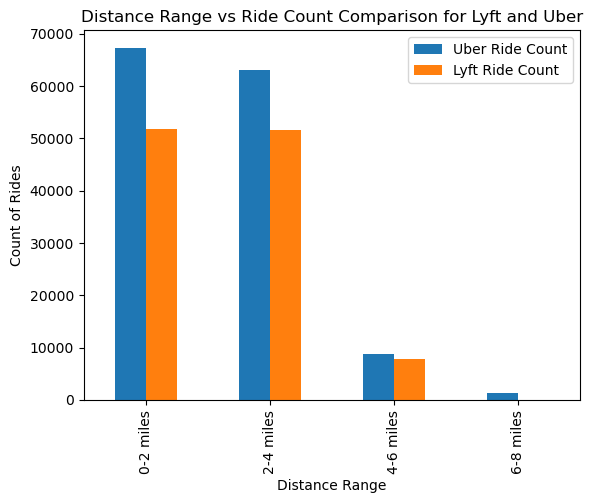

In [18]:
# Plotting a bar chart to show rides taken for various distance ranges per rideshare app
ax=range_df.plot.bar()
labels=range_df["Distance Range"]
ax.set_xticklabels(labels)
plt.title("Distance Range vs Ride Count Comparison for Lyft and Uber")
plt.xlabel("Distance Range")
plt.ylabel("Count of Rides")
plt.savefig("Images/2_2.png")
plt.show()

2.C Knowing the number of rides taken for each rideshare app, how does this translate into overall revenue earned by Uber vs Lyft?

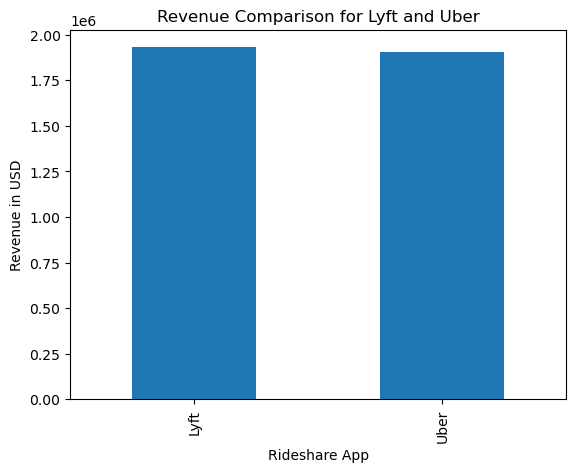

In [19]:
# Total revenue for both lyft and uber
revenue_df=final_df.groupby("Rideshare_App")["Price($)"].sum()

#Bar plot showing the revenue base on both rideshare apps
revenue_df.plot(kind='bar')
plt.title("Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.savefig("Images/2_3.png")
plt.show()


In [20]:
# For a deeper dive, let's look at revenue per month for each rideshare app
lyft=final_df[final_df["Rideshare_App"]=="Lyft"]
lyft_monthly_rev=lyft.groupby("Month")["Price($)"].sum()

uber=final_df[final_df["Rideshare_App"]=="Uber"]
uber_monthly_rev=uber.groupby(["Month"])["Price($)"].sum()

# Create a Dataframe to show revenue based on each rideshare app
monthly_rev_df=pd.DataFrame({"Lyft":lyft_monthly_rev,"Uber":uber_monthly_rev})
monthly_rev_df

,Lyft,Uber
Month,,
11,1126795.80,1117151.5
12,803659.35,785612.5


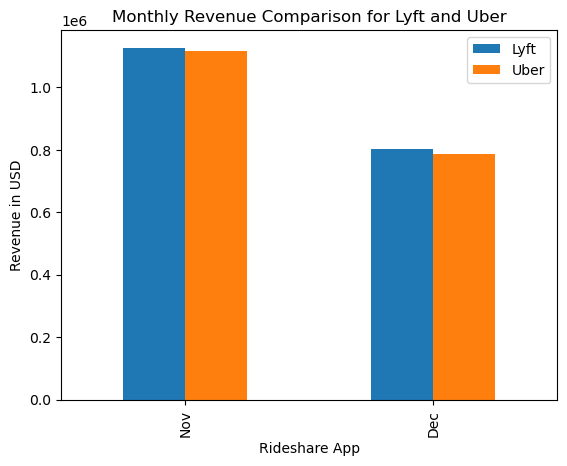

In [21]:
# Plotting a bar chart to show revenue based on month, per rideshare app
ax=monthly_rev_df.plot.bar()
labels=['Nov','Dec']
ax.set_xticklabels(labels)
plt.title("Monthly Revenue Comparison for Lyft and Uber")
plt.xlabel("Rideshare App")
plt.ylabel("Revenue in USD")
plt.savefig("Images/2_4.png")
plt.show()

2.D At what time do people prefer to take an Uber vs. Lyft? Is there a behavioral trend that differentiates how people use these apps?

In [22]:
# In order to look at the number of rides taken per hour, we need to extract the information from the timestamps

final_df["Hour"]=final_df["Date"].dt.hour
final_df.head()

,Date,Weekday,Month,Pick_Up_Location,Destination,Distance(m),Price($),Surge_Multiplier,Rideshare_App,Ride_Type,Temp(C),Cloudiness(%),Pressure(MB),Rainfall(in),Humidity(%),Wind_Speed(mph),Hour
0,2018-11-26 03:40:46.318000128,Monday,11,Boston University,Theatre District,3.03,34.0,1.0,Lyft,Lux Black XL,41.07,86.0,1014.39,0.0,92.0,1.36,3
1,2018-11-26 03:40:46.319000064,Monday,11,Theatre District,North End,1.57,0.0,1.0,Uber,Taxi,40.80,87.0,1014.39,0.0,93.0,1.55,3
2,2018-11-26 03:40:46.319000064,Monday,11,South Station,Theatre District,1.30,18.5,1.0,Uber,Black,40.86,87.0,1014.39,0.0,93.0,1.60,3
3,2018-11-26 03:40:46.320000000,Monday,11,Theatre District,Fenway,2.71,19.5,1.0,Uber,UberX,40.80,87.0,1014.39,0.0,93.0,1.55,3
4,2018-11-26 03:40:46.320000000,Monday,11,Northeastern University,Beacon Hill,2.43,10.5,1.0,Lyft,Lyft,40.81,89.0,1014.35,0.0,93.0,1.36,3


In [23]:
# Let's find average number of Uber Rides taken per day and per hour

uber=final_df.loc[final_df["Rideshare_App"]=="Uber"]

grouped_hour_day = uber.groupby(["Hour", "Weekday"])
ride_count_by_hour_day = grouped_hour_day.size()

mean_rides_uber = ride_count_by_hour_day.groupby(["Hour", "Weekday"]).mean()
print(mean_rides_uber)

Hour  Weekday  
0     Friday        516.0
      Monday        644.0
      Saturday      475.0
      Sunday        501.0
      Thursday     2336.0
                    ...  
23    Saturday      529.0
      Sunday        844.0
      Thursday      489.0
      Tuesday       828.0
      Wednesday    2345.0
Length: 163, dtype: float64


In [24]:
# Let's find average number of Lyft Rides taken per day and per hour

lyft=final_df.loc[final_df["Rideshare_App"]=="Lyft"]

grouped_hour_day = lyft.groupby(["Hour", "Weekday"])
ride_count_by_hour_day = grouped_hour_day.size()

mean_rides_lyft = ride_count_by_hour_day.groupby(["Hour", "Weekday"]).mean()
print(mean_rides_lyft)

Hour  Weekday  
0     Friday        420.0
      Monday        436.0
      Saturday      461.0
      Sunday        435.0
      Thursday     1879.0
                    ...  
23    Saturday      407.0
      Sunday        681.0
      Thursday      447.0
      Tuesday       732.0
      Wednesday    1711.0
Length: 163, dtype: float64


In [25]:
# Defining a function that'll allow us to easily plot some timeseries graphs

def plot(dataframe):
# Create a list of weekdays to use as labels
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a figure and axis objects
    fig, ax = plt.subplots(figsize=(10,6))

# Iterate over each weekday and plot a line for the count of car rides
    for weekday in weekdays:
        data = dataframe.loc[dataframe.index.get_level_values('Weekday') == weekday]
        ax.plot(data.index.get_level_values('Hour'), data, label=weekday)


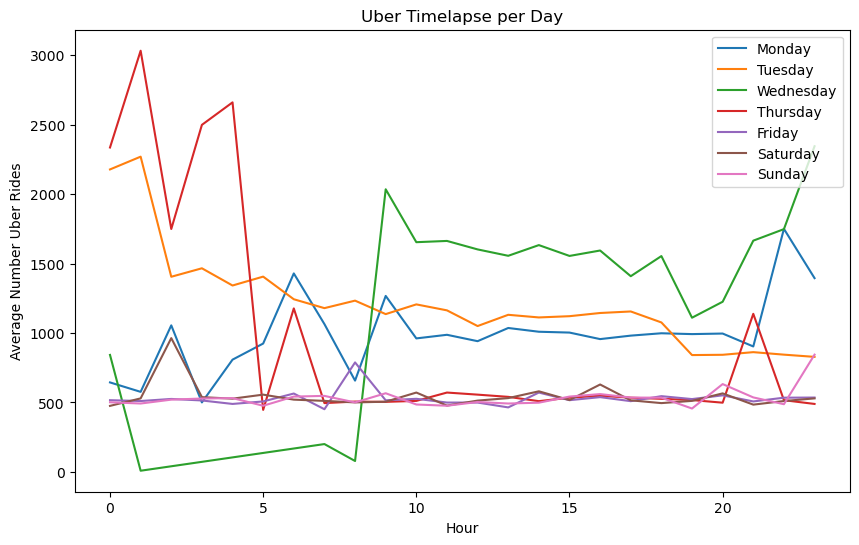

In [26]:
# Average Rides for Uber Timeseries
plot(mean_rides_uber)

# Set the x-axis and y-axis labels
plt.xlabel('Hour')
plt.ylabel('Average Number Uber Rides')
plt.title("Uber Timelapse per Day")

# Add a legend
plt.legend(loc="upper right")

# Show the plot
plt.savefig("Images/2_5.png")
plt.show()

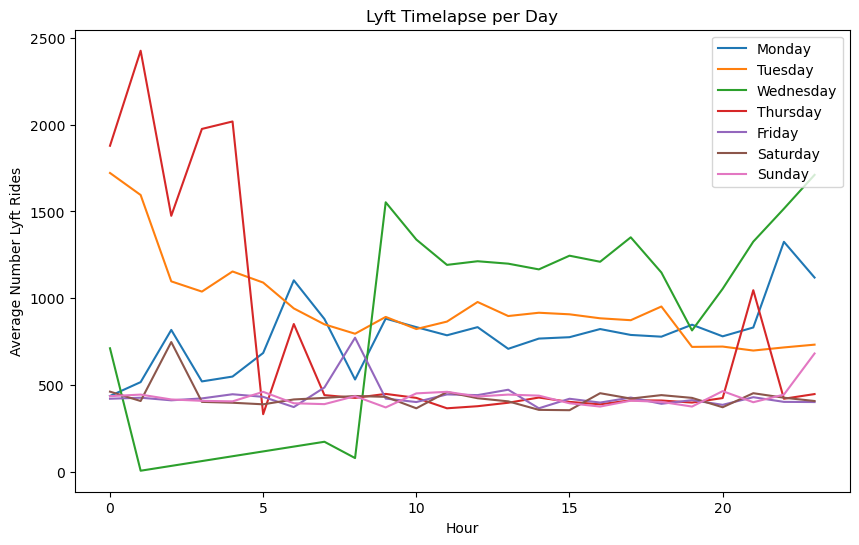

In [27]:
# Average Rides for Lyft Timeseries
plot(mean_rides_lyft)

# Set the x-axis and y-axis labels
plt.xlabel('Hour')
plt.ylabel('Average Number Lyft Rides')
plt.title("Lyft Timelapse per Day")

# Add a legend
plt.legend(loc="upper right")

# Show the plot
plt.savefig("Images/2_6.png")
plt.show()

2.E What Ride Types do people prefer across an average day?

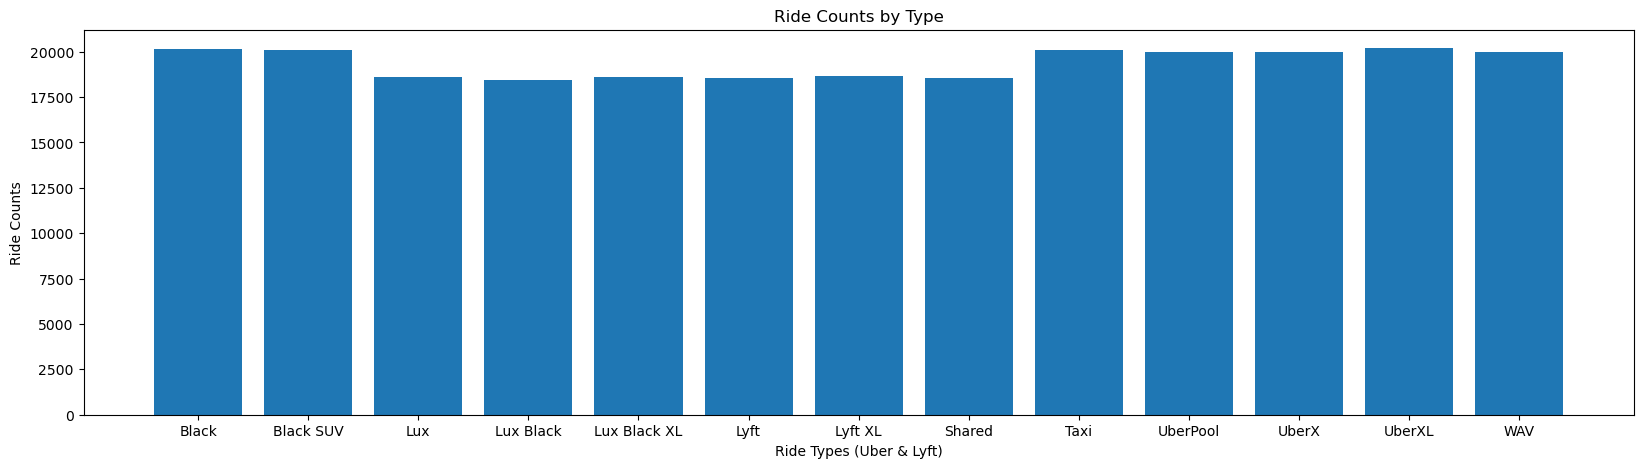

In [28]:
# Let's regroup our data to identify ride types for each app

grouped_data=final_df.groupby("Ride_Type")
ride_type_counts=grouped_data["Destination"].count()

plt.figure(figsize=(20,5))
plt.bar(ride_type_counts.index,height=ride_type_counts.values)
plt.xlabel("Ride Types (Uber & Lyft)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts by Type")
plt.savefig("Images/2_7.png")
plt.show()

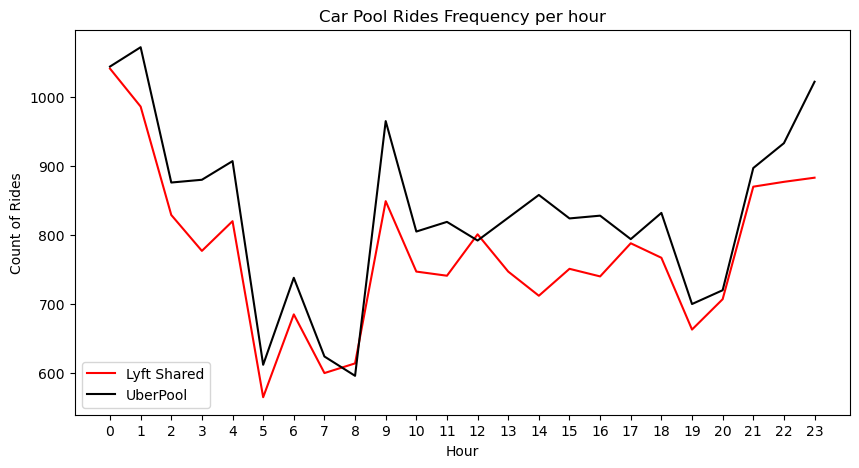

In [70]:
# Since there isn't a lot of variation of rides by ride type, let's compare the frequency of shared ride types Lyft Shared and UberPool

days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

shared=final_df.loc[final_df["Ride_Type"]=="Shared"]
shared_count=shared.groupby("Hour")["Destination"].count()

uberpool=final_df.loc[final_df["Ride_Type"]=="UberPool"]
uberpool_count=uberpool.groupby("Hour")["Destination"].count()

plt.figure(figsize=(10,5))

plt.plot(shared_count.index,shared_count.values,c="red", label="Lyft Shared")
plt.plot(uberpool_count.index,uberpool_count.values,c="black", label="UberPool")
plt.xticks(shared_count.index)

plt.xlabel("Hour")
plt.ylabel("Count of Rides")
plt.title("Car Pool Rides Frequency per hour")
plt.legend()
plt.savefig("Images/2_8.png")
plt.show()

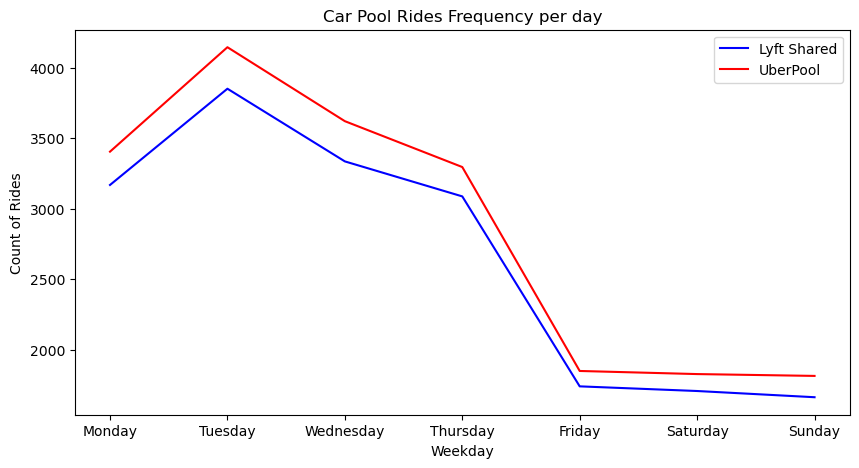

In [71]:
# Calculating Frequency of Rides across a week for extra measure

shared_count=shared.groupby("Weekday")["Ride_Type"].count()
shared_count=shared_count.reindex(days).reset_index()

uberpool_count=uberpool.groupby("Weekday")["Ride_Type"].count()
uberpool_count=uberpool_count.reindex(days).reset_index()

plt.figure(figsize=(10,5))

plt.plot(shared_count['Weekday'],shared_count['Ride_Type'],c="blue", label="Lyft Shared")
plt.plot(uberpool_count['Weekday'],uberpool_count['Ride_Type'],c="red", label="UberPool")

plt.xticks(shared_count.index)
plt.xlabel("Weekday")
plt.ylabel("Count of Rides")
plt.title("Car Pool Rides Frequency per day")
plt.legend()
plt.savefig("Images/2_9.png")
plt.show()

## Part 3 - How are Car Rides Affected by Weather?
----
#### Weather plays a pivotal role in commute! In our given data, there are plausible elements of nature that could potentially affect how one gets from point A to point B. Now that we have a general idea of what app is preferable, let's add a second layer to the analyses.

3.A How do factors like rain, wind speed and cloudiness affect one's preference to use Rideshare Apps? Is one app used more than the other? Is the frequency of rides affected with worse weather conditions?

In [31]:
# In order to better visualize the amount of rainfall, we need to convert our unit of measurement to millimeters and also derive count of rides per day

final_df["Rainfall(mm)"]=final_df["Rainfall(in)"]*25.4
final_df["Date by hour"]=final_df["Date"].dt.strftime("%Y-%m-%d %H:%M")
day_grouped=final_df.groupby("Date by hour")

# Making a list of days in the given week. This will eventually be our x-axis
days_of_the_week=final_df["Date by hour"].unique()

# Splitting the edited dataframe by Rideshare App
uber_split = final_df.loc[final_df["Rideshare_App"]=="Uber"]
lyft_split = final_df.loc[final_df["Rideshare_App"]=="Lyft"]

In [32]:
# Finding out the count of rides taken per day of the week for Uber

uber_grouped=uber_split.groupby(["Date by hour"])
uber_ride_count=uber_grouped.count()["Destination"]
uber_ride_count.head()

Date by hour
2018-11-26 03:40    41
2018-11-26 04:40    52
2018-11-26 04:41    55
2018-11-26 04:43    50
2018-11-26 04:49    48
Name: Destination, dtype: int64

In [33]:
# Finding out the count of rides taken per day of the week for Uber

lyft_grouped=lyft_split.groupby(["Date by hour"])
lyft_ride_count=lyft_grouped.count()["Destination"]
lyft_ride_count.head()

Date by hour
2018-11-26 03:40    43
2018-11-26 04:40    32
2018-11-26 04:41    29
2018-11-26 04:43    34
2018-11-26 04:49    36
Name: Destination, dtype: int64

In [34]:
# Finding average rainfall each day

ave_rainfall=day_grouped.mean()["Rainfall(mm)"]
ave_rainfall.head()

Date by hour
2018-11-26 03:40    0.0
2018-11-26 04:40    0.0
2018-11-26 04:41    0.0
2018-11-26 04:43    0.0
2018-11-26 04:49    0.0
Name: Rainfall(mm), dtype: float64

In [35]:
# Finding average wind speed each day

ave_wind_speed=day_grouped.mean()["Wind_Speed(mph)"]
ave_wind_speed.head()

Date by hour
2018-11-26 03:40    1.485952
2018-11-26 04:40    2.584048
2018-11-26 04:41    2.595238
2018-11-26 04:43    2.641310
2018-11-26 04:49    2.611190
Name: Wind_Speed(mph), dtype: float64

In [36]:
# Finding average wind speed each day

ave_cloudiness=day_grouped.mean()["Cloudiness(%)"]
ave_cloudiness.head()

Date by hour
2018-11-26 03:40    87.309524
2018-11-26 04:40    86.452381
2018-11-26 04:41    86.428571
2018-11-26 04:43    85.892857
2018-11-26 04:49    94.511905
Name: Cloudiness(%), dtype: float64

In [37]:
# Create the final dataframe for plotting

rides_vs_weather = pd.DataFrame({"Uber Ride Count":uber_ride_count,"Lyft Ride Count":lyft_ride_count,"Average Rainfall (mm)":ave_rainfall,"Average Wind Speed (mph)":ave_wind_speed, "Average Cloudiness (%)":ave_cloudiness},index=days_of_the_week)
rides_vs_weather.head()

,Uber Ride Count,Lyft Ride Count,Average Rainfall (mm),Average Wind Speed (mph),Average Cloudiness (%)
2018-11-26 03:40,41.0,43.0,0.0,1.485952,87.309524
2018-11-26 04:40,52.0,32.0,0.0,2.584048,86.452381
2018-11-26 04:41,55.0,29.0,0.0,2.595238,86.428571
2018-11-26 04:43,50.0,34.0,0.0,2.641310,85.892857
2018-11-26 04:49,48.0,36.0,0.0,2.611190,94.511905


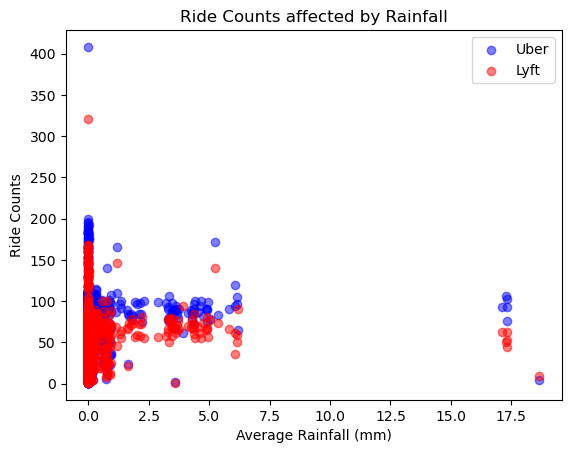

In [38]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
plt.scatter(rides_vs_weather["Average Rainfall (mm)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
plt.scatter(rides_vs_weather["Average Rainfall (mm)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

plt.legend()

plt.xlabel("Average Rainfall (mm)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts affected by Rainfall")
plt.savefig("Images/3_1.png")
plt.show()

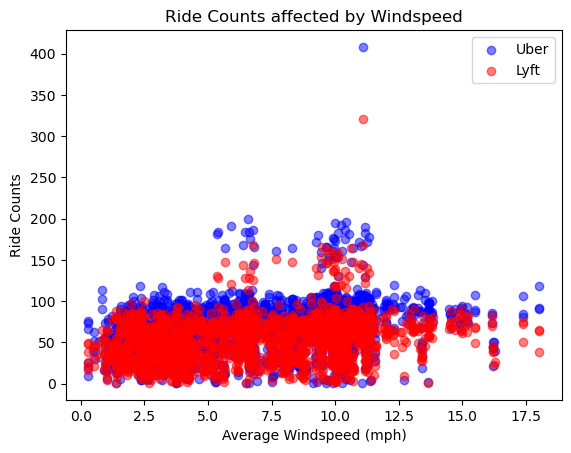

In [39]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
plt.scatter(rides_vs_weather["Average Wind Speed (mph)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
plt.scatter(rides_vs_weather["Average Wind Speed (mph)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

plt.legend()

plt.xlabel("Average Windspeed (mph)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts affected by Windspeed")
plt.savefig("Images/3_2.png")
plt.show()

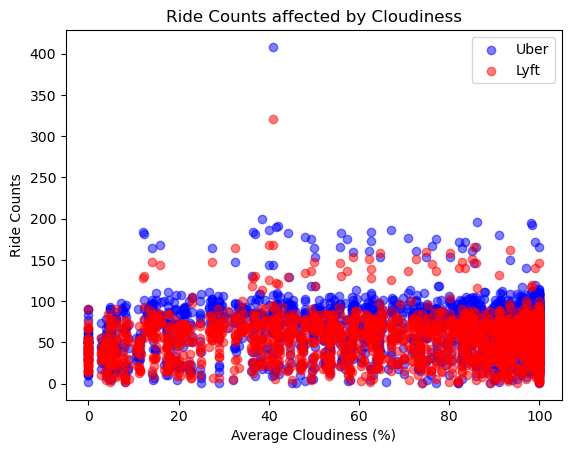

In [40]:
# Creating a scatter plot to show count of rides per app compared against average rainfall at a given time
plt.scatter(rides_vs_weather["Average Cloudiness (%)"], rides_vs_weather["Uber Ride Count"], c='blue', alpha=0.5, label='Uber')
plt.scatter(rides_vs_weather["Average Cloudiness (%)"], rides_vs_weather["Lyft Ride Count"], c='red', alpha=0.5, label='Lyft')

plt.legend()

plt.xlabel("Average Cloudiness (%)")
plt.ylabel("Ride Counts")
plt.title("Ride Counts affected by Cloudiness")
plt.savefig("Images/3_3.png")
plt.show()

3.B Do these weather conditions affect how far people travel?

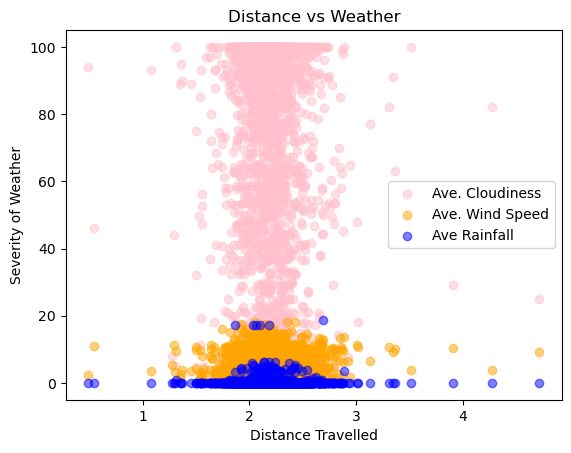

In [41]:
# Creating a scatter plot to show how distance travelled is related to different weather conditions, now assuming that Uber is the preferred app to use

ave_distance=day_grouped["Distance(m)"].mean()

plt.scatter(ave_distance,rides_vs_weather["Average Cloudiness (%)"], c="pink", alpha=0.5, label="Ave. Cloudiness")
plt.scatter(ave_distance,rides_vs_weather["Average Wind Speed (mph)"], c="orange", alpha=0.5, label="Ave. Wind Speed")
plt.scatter(ave_distance,rides_vs_weather["Average Rainfall (mm)"], c="blue", alpha=0.5, label="Ave Rainfall")

plt.xlabel("Distance Travelled")
plt.ylabel("Severity of Weather")
plt.title("Distance vs Weather")
plt.legend()
plt.savefig("Images/3_4.png")
plt.show()

## Part 4 - Rideshare Behavior & Pricing
----
#### Two main points that we've derived from our previous analyses is that though most people prefer to use Uber, the overall revenue for Lyft is higher. We also know that Uber is the popular choice to take when the weather isn't pleasant. In this part, we'll dig deeper into how these relationships play out into their pricing.

4.A What does a summary analysis of pricing look like for our data?

In [42]:
#Generate a summary statistics of mean, median, variance, standard deviation, and SEM of the price for Lyft and Uber 

ride_app = final_df.groupby("Rideshare_App")

count_rides = ride_app["Price($)"].count()
mean_price = ride_app["Price($)"].mean()
median_price = ride_app["Price($)"].median()
var_price = ride_app["Price($)"].var()
std_price = ride_app["Price($)"].std()
sem_price = ride_app["Price($)"].sem()
min_price = ride_app["Price($)"].min()
max_price = ride_app["Price($)"].max()
price_rideApp_df = pd.DataFrame({"Price Mean":mean_price , 
                            "Price Median ":median_price,
                             "Price Variance":var_price,
                             "Price Std. Dev.":std_price,
                             "Price Std. Err.":sem_price,
                                "Total rides" :count_rides,
                                "Max Price" : max_price,
                                "Min Price": min_price})

price_rideApp_df

,Price Mean,Price Median,Price Variance,Price Std. Dev.,Price Std. Err.,Total rides,Max Price,Min Price
Rideshare_App,,,,,,,,
Lyft,17.335110,16.5,100.338586,10.016915,0.030017,111361,92.0,2.5
Uber,13.546082,11.0,93.315272,9.659983,0.025775,140466,89.5,0.0


4.B How do prices change depending on the day of the week?

In [43]:
# Create a sorted list of days

days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [44]:
# Since we have previously split our final data frame into separate rideshare apps, we can find the average price of rides for each app on a given day of the week
# For Lyft
lyft_price = lyft_split.groupby(["Weekday"])["Price($)"].mean().reindex(days)
lyft_price

Weekday
Monday       17.301735
Tuesday      17.312292
Wednesday    17.251150
Thursday     17.424526
Friday       17.288538
Saturday     17.219977
Sunday       17.609578
Name: Price($), dtype: float64

In [45]:
# For Uber
uber_price = uber_split.groupby(["Weekday"])["Price($)"].mean().reindex(days)
uber_price

Weekday
Monday       13.540345
Tuesday      13.556304
Wednesday    13.520725
Thursday     13.599944
Friday       13.414310
Saturday     13.557390
Sunday       13.604709
Name: Price($), dtype: float64

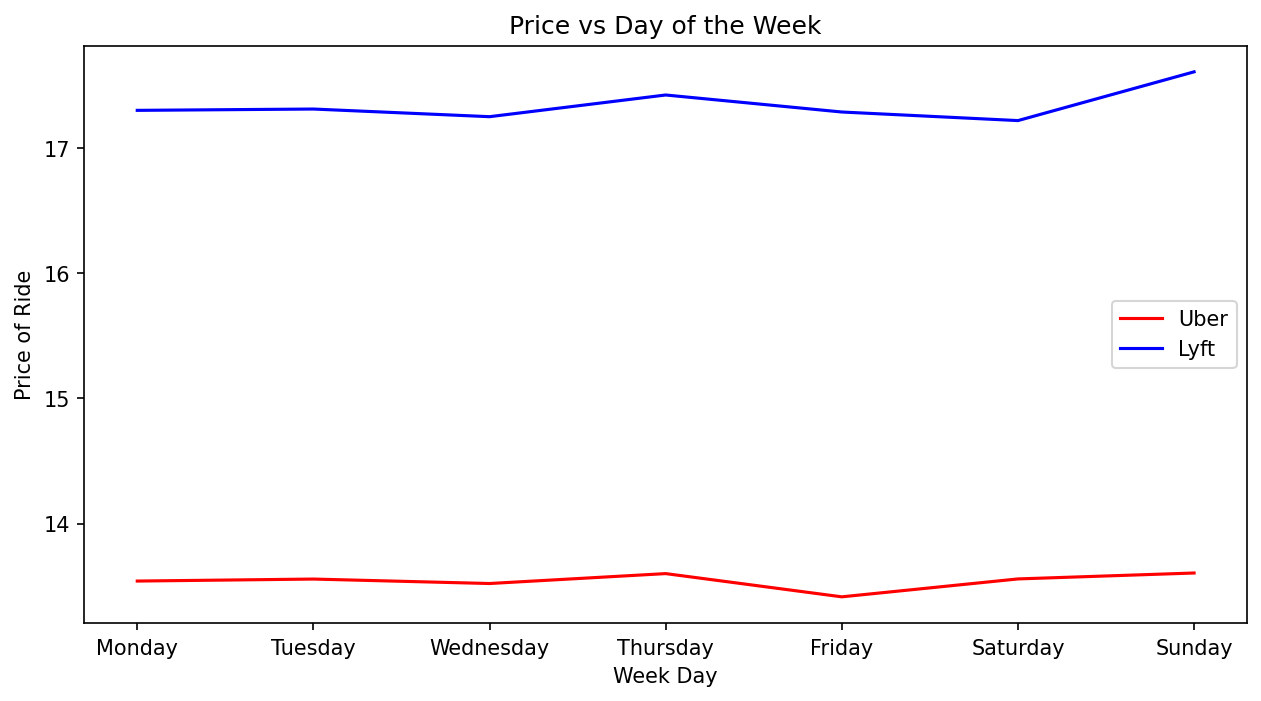

In [46]:
# Creating a line chart to observe the daily distribution of pricing per Rideshare App

plt.figure(figsize=(10, 5), dpi=150)
uber_price.plot(color ="r", label ="Uber")
lyft_price.plot(color ="b", label ="Lyft")

plt.xlabel("Week Day")
plt.ylabel("Price of Ride")
plt.title("Price vs Day of the Week") 
plt.legend()
plt.savefig("Images/4_1.png")
plt.show()


4.C We now know that Lyft on average charges more per ride than Uber, but how does the ride to distance relationship work? How is pricing stipulated?

In [47]:
# Binning the distance

bins = [0,1,2,3,4,5,6,7,8]
uber_split["dist"] =  pd.cut(final_df["Distance(m)"].astype(float),bins)
lyft_split["dist"] =  pd.cut(final_df["Distance(m)"].astype(float),bins)

In [48]:
# Calculate the correlation coefficient and a linear regression model for price and distance based on the app used
# For Uber and Lyft

uber_dist=uber_split.groupby("dist").mean()
lyft_dist=lyft_split.groupby("dist").mean()
lyft_dist=lyft_dist.dropna()

# Count the number of Lyft rides within each distance range

uber_prices = uber_dist["Price($)"]
uber_distance = uber_dist["Distance(m)"]
lyft_prices = lyft_dist["Price($)"]
lyft_distance = lyft_dist["Distance(m)"]

corr_uber = round(st.pearsonr(uber_distance, uber_prices)[0],2)
corr_lyft = round(st.pearsonr(lyft_distance, lyft_prices)[0],2)
print(f"The correlation between price of Uber rides and the Distance {corr_uber}")
print(f"The correlation between price of Lyft rides and the Distance {corr_lyft}")

# Plotting linear regression graph
linear_reg_uber = st.linregress(uber_distance,uber_prices)
linear_reg_lyft = st.linregress(lyft_distance,lyft_prices)

The correlation between price of Uber rides and the Distance 0.98
The correlation between price of Lyft rides and the Distance 1.0


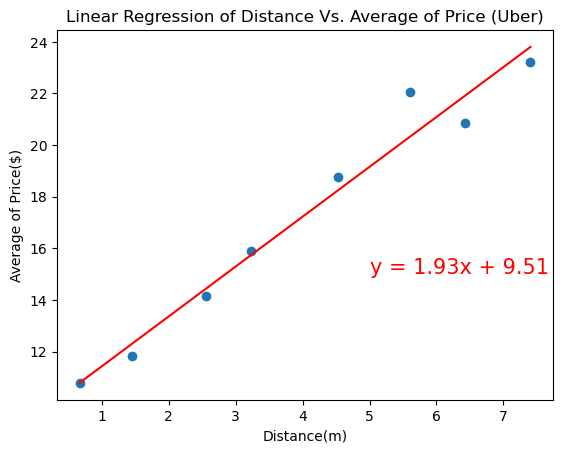

In [49]:
# Plot the regression line on the scatter plot for Uber

plt.scatter(uber_distance, uber_prices)

uber_price_predict = uber_distance * linear_reg_uber.slope + linear_reg_uber.intercept
plt.plot(uber_distance, uber_price_predict, color='red')
line_eq = "y = " + str(round(linear_reg_uber.slope,2)) + "x + " + str(round(linear_reg_uber.intercept,2))
plt.annotate(line_eq,(5,15),fontsize=15,color="red")

plt.title("Linear Regression of Distance Vs. Average of Price (Uber)")
plt.xlabel("Distance(m)")
plt.ylabel("Average of Price($)")
plt.savefig("Images/4_2.png")
plt.show()

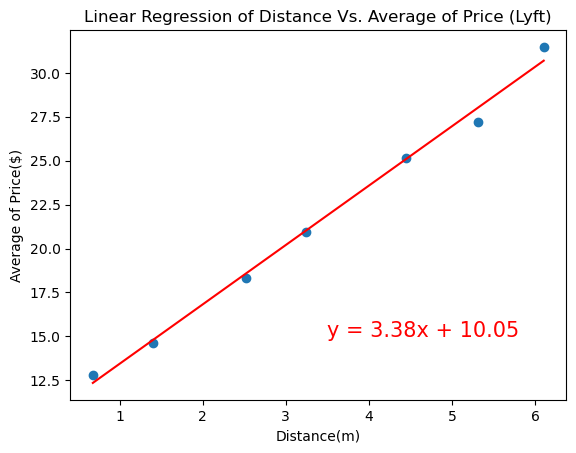

In [50]:
# Plot the regression line on the scatter plot for Lyft

plt.scatter(lyft_distance, lyft_prices)

lyft_price_predict = lyft_distance * linear_reg_lyft.slope + linear_reg_lyft.intercept
plt.plot(lyft_distance, lyft_price_predict, color='red')
line_eq = "y = " + str(round(linear_reg_lyft.slope,2)) + "x + " + str(round(linear_reg_lyft.intercept,2))
plt.annotate(line_eq,(3.5,15),fontsize=15,color="red")

plt.title("Linear Regression of Distance Vs. Average of Price (Lyft)")
plt.xlabel("Distance(m)")
plt.ylabel("Average of Price($)")
plt.savefig("Images/4_3.png")
plt.show()

4.D According to our linear regression tables, we see that Lyft charges twice as much for extra miles on top of the base trip value! This evidently speaks to surge multipliers work. When are these surges more prevalent? Which app has higher surges?

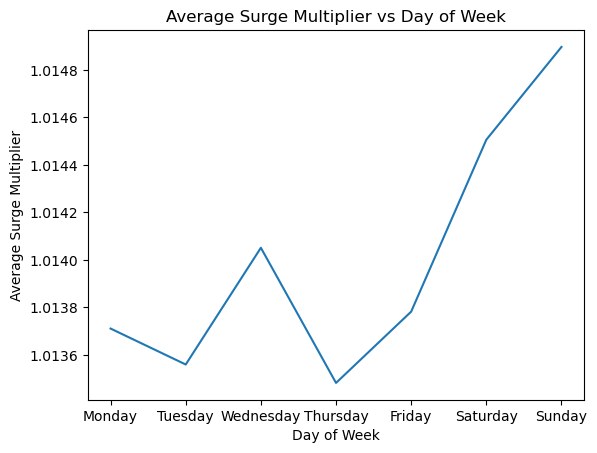

In [51]:
# Finding the mean surge of our entire data
surge_df = final_df.groupby('Weekday')['Surge_Multiplier'].mean().reindex(days)

# Plotting these values on a line graph
plt.plot(surge_df.index,surge_df.values)
plt.title("Average Surge Multiplier vs Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Surge Multiplier")
plt.savefig("Images/4_4.png")
plt.show()

In [52]:
# Comparing mean surge values for Apps
mean_surge=final_df.groupby("Rideshare_App").mean()["Surge_Multiplier"]
mean_surge

Rideshare_App
Lyft    1.031414
Uber    1.000000
Name: Surge_Multiplier, dtype: float64

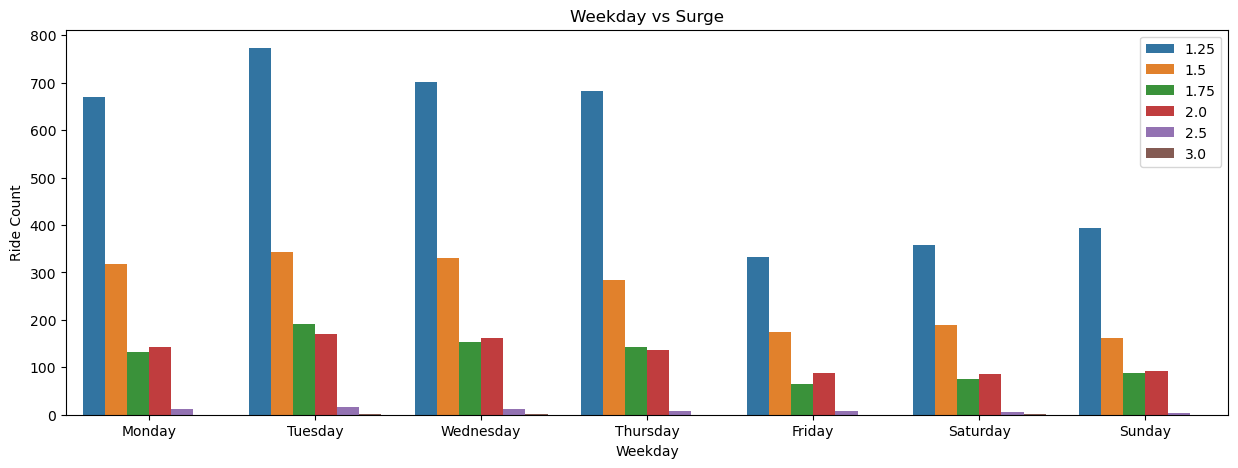

In [53]:
# Knowing that Uber doesn't charge surge rates, let's see how Lyft rides are affected by surge per day
# Separating our lyft data to only show us rides with surge rates > 1

lyft_surge=lyft_split.loc[lyft_split["Surge_Multiplier"]>1]

lyft_surge_df = pd.DataFrame(lyft_surge.groupby(["Weekday", "Surge_Multiplier"]).size().reset_index())
lyft_surge_df.columns = ["Weekday", "Surge", "Ride Count"]

plt.figure(figsize=(15, 5))
sns.barplot(x="Weekday", y="Ride Count", hue="Surge", data=lyft_surge_df, order=days).set_title("Weekday vs Surge")
plt.legend(loc="upper right")
plt.savefig("Images/4_5.png")
plt.show()

## Part 5 - Where is everyone headed to?
----
#### So longer distances mean more revenue, right? Perhaps that could also influence how surge multipliers are factored in. However, how does this all add up, when we look at our pick up and drop off locations?


5.A What are our top pick-up and drop-off locations?

In [54]:
# Grouping data by pickup and dropoff locations
# Top Pick up Locations
pickup = final_df.groupby("Pick_Up_Location").size().sort_values(ascending=False)
pickup.head(3)

Pick_Up_Location
Haymarket Square           21483
Northeastern University    21339
South Station              21056
dtype: int64

In [55]:
# Top Destinations
destination = final_df.groupby("Destination").size().sort_values(ascending=False)
destination.head(3)

Destination
Financial District    21842
Back Bay              21148
Beacon Hill           21142
dtype: int64

In [56]:
def location_plot(location,entity):

    # Unique pick-up locations
    unique_values = final_df[location].unique()

    # Create a figure and axis to hold the subplots
    fig, ax = plt.subplots()

    # Perform normality test and create histograms for each pick-up location
    for value in unique_values:
        # Filter dataframe for the current pick-up location
        filtered_df = final_df[final_df[location] == value]
    
        # Perform normality test on price column
        _, p_value = st.normaltest(filtered_df[entity])
    
        # Create histogram with some transparency (alpha=0.5)
        ax.hist(filtered_df[entity], bins=20, alpha=0.5, label=value)
        print(f"{value} - Normality Test (p-value: {p_value})")

    # Set plot labels and title
    ax.set_title(f'{entity} Distribution by {location}')
    ax.set_xlabel(f'{entity}')
    ax.set_ylabel('Counts')

    # Add a legend to differentiate pick-up locations
    ax.legend()
    plt.savefig(f"Images/5_{entity}_{location}.png")

    # Display the plot
    plt.show()


Boston University - Normality Test (p-value: 0.0)
Theatre District - Normality Test (p-value: 0.0)
South Station - Normality Test (p-value: 1.4972364380507947e-253)
Northeastern University - Normality Test (p-value: 0.0)
Beacon Hill - Normality Test (p-value: 6.2777448380611325e-226)
North Station - Normality Test (p-value: 1.5373150744723177e-233)
Haymarket Square - Normality Test (p-value: 0.0)
West End - Normality Test (p-value: 8.812242012145911e-222)
North End - Normality Test (p-value: 1.686898073443695e-233)
Financial District - Normality Test (p-value: 0.0)
Fenway - Normality Test (p-value: 0.0)
Back Bay - Normality Test (p-value: 0.0)


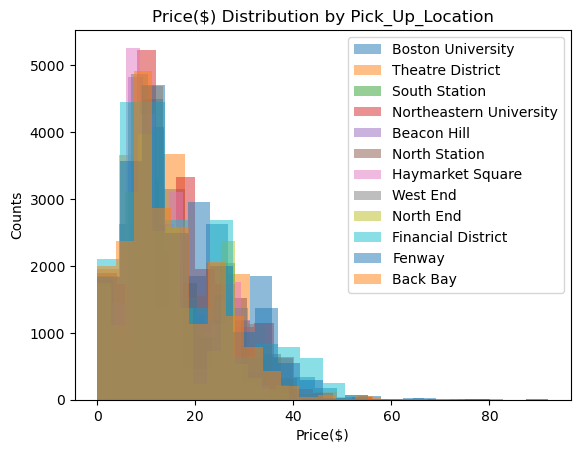

<Figure size 640x480 with 0 Axes>

In [57]:
location_plot("Pick_Up_Location","Price($)")
plt.savefig("Images/5_1.png")

Theatre District - Normality Test (p-value: 1.5931126649811533e-281)
North End - Normality Test (p-value: 0.0)
Fenway - Normality Test (p-value: 8.73411284106e-312)
Beacon Hill - Normality Test (p-value: 1.1638201165338657e-202)
Northeastern University - Normality Test (p-value: 7.970794074450303e-273)
Financial District - Normality Test (p-value: 0.0)
Boston University - Normality Test (p-value: 0.0)
Haymarket Square - Normality Test (p-value: 0.0)
West End - Normality Test (p-value: 0.0)
South Station - Normality Test (p-value: 0.0)
North Station - Normality Test (p-value: 0.0)
Back Bay - Normality Test (p-value: 3.553239483960572e-251)


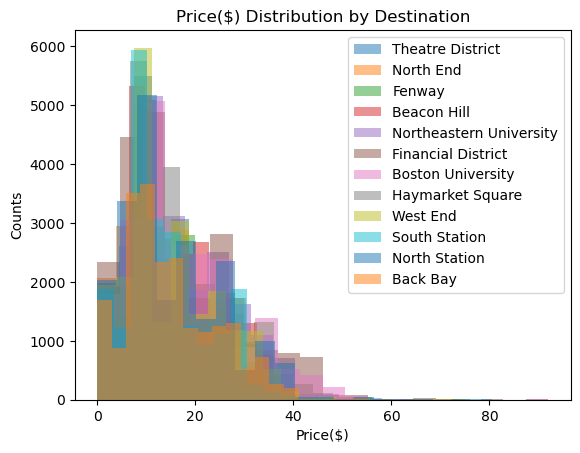

<Figure size 640x480 with 0 Axes>

In [58]:
location_plot("Destination","Price($)")
plt.savefig("Images/5_2.png")

Lyft - Normality Test (p-value: 0.0)
Uber - Normality Test (p-value: 0.0)


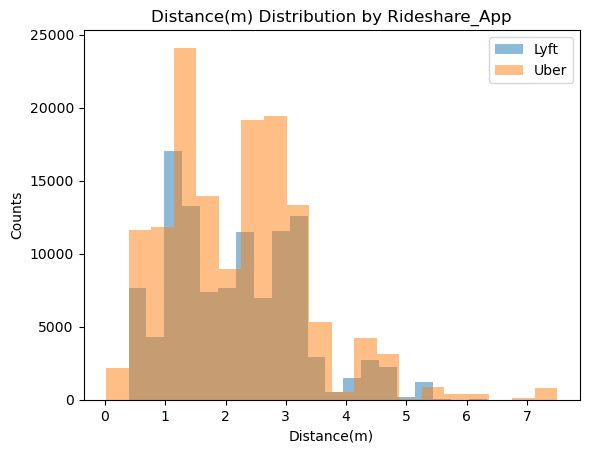

<Figure size 640x480 with 0 Axes>

In [59]:
location_plot("Rideshare_App","Distance(m)")
plt.savefig("Images/5_3.png")

## Part 6 - Statistical Analysis of Ride-Weather Data & ANOVA Testing
---
#### Additional Correlation Heatmap Testing along with box plot data


6.A Are there generally any outliers with how each App prices their rides?

In [60]:
# create rides into list for loop
ride_list = ["Lyft", "Uber"]

#Create empty list to fill with price data (for plotting)
price_list =[]

for ride in ride_list:
    
    price = final_df[ final_df["Rideshare_App"]==ride]["Price($)"] 
    
    price_list.append(price)
    
    # Determine outliers using upper and lower bounds
    quartiles = price.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    # print if the counter is empty and add a space between each regimen
    
   
    print(f"The IQR data for {ride} is:")
    print(f"The lower quartile of {ride} is: {lowerq}")
    print(f"The upper quartile of {ride} is: {upperq}")
    print(f"The interquartile range of {ride} is: {iqr}")
    print(f"The the median of {ride} is: {quartiles[0.5]}")
    print(f"Values below {lower_bound} could be outliers.")
    print(f"Values above {upper_bound} could be outliers.")
    print(f"")
   

The IQR data for Lyft is:
The lower quartile of Lyft is: 9.0
The upper quartile of Lyft is: 22.5
The interquartile range of Lyft is: 13.5
The the median of Lyft is: 16.5
Values below -11.25 could be outliers.
Values above 42.75 could be outliers.

The IQR data for Uber is:
The lower quartile of Uber is: 7.5
The upper quartile of Uber is: 19.0
The interquartile range of Uber is: 11.5
The the median of Uber is: 11.0
Values below -9.75 could be outliers.
Values above 36.25 could be outliers.



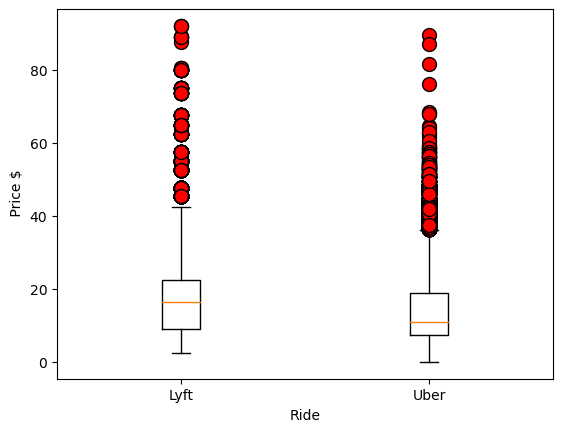

In [61]:
# Generate a box plot that shows the distrubution of the price based on each ride app.
flierprops = dict(marker='o', markerfacecolor='r', markersize=10, markeredgecolor='black')

fig1, ax1 = plt.subplots()
ax1.set_ylabel(" Price $")
ax1.set_xlabel("Ride")
ax1.boxplot(price_list, flierprops=flierprops)
ax1.set_xticklabels(ride_list)
plt.savefig("Images/6_1.png")
plt.show()


6.B How do various fields in our dataframe correlate with each other and what conclusions can we derive?

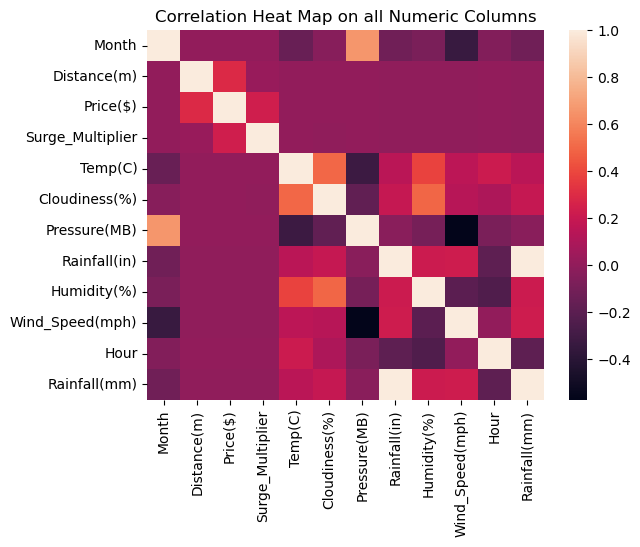

In [62]:
# Plot the correlation heat map among numeric columns
# Calculate the correlation matrix on the numeric columns
corr = final_df.select_dtypes('number').corr()

# Plot the heatmap
sns.heatmap(corr)
plt.title("Correlation Heat Map on all Numeric Columns")
plt.savefig("Images/6_2.png")
plt.show()


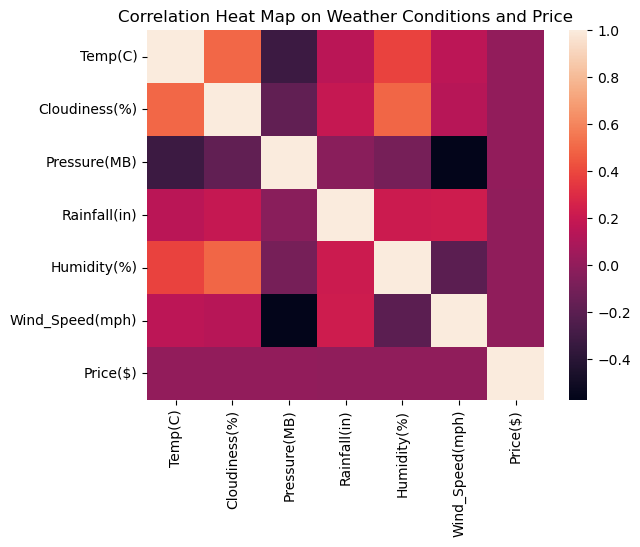

In [63]:
# Calculate the correlation matrix on the weather conditions and price
conditions_list = ["Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)","Price($)"]

corr = final_df.loc[:,conditions_list].select_dtypes('number').corr()

# Plot the heatmap
sns.heatmap(corr)
plt.title("Correlation Heat Map on Weather Conditions and Price")
plt.savefig("Images/6_3.png")
plt.show()

In [64]:
# Aggregate the data to calculate the Average Revenue on a given day

# Create a field to extract the day, and group data by day
final_df["day"] = final_df["Date"].dt.date
by_date_df = final_df.groupby("day")

# Aggregate the price column to get the revenue 
revenue = by_date_df["Price($)"].sum()
by_date_df = by_date_df.mean()
by_date_df["Revenue"] = revenue

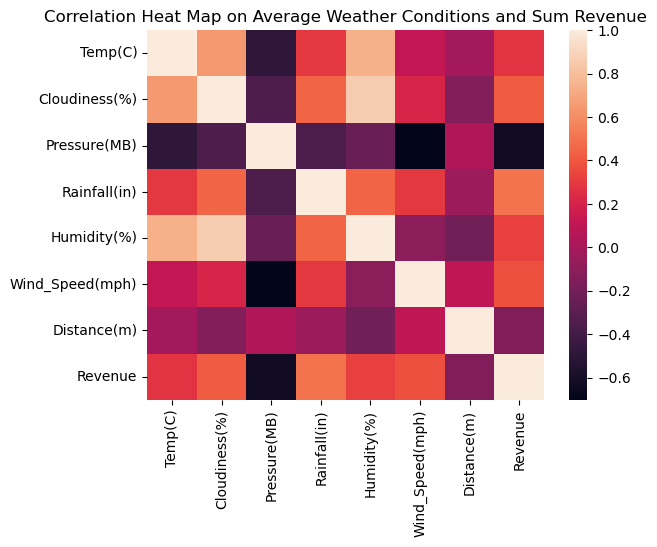

In [65]:
# Calculate the correlation matrix on revenue based on the wehater conditions on specific days
conditions_list = ["Temp(C)","Cloudiness(%)","Pressure(MB)","Rainfall(in)","Humidity(%)","Wind_Speed(mph)","Distance(m)","Revenue"]

corr = by_date_df.loc[:,conditions_list].select_dtypes('number').corr()


# Plot the heatmap
sns.heatmap(corr)
plt.title("Correlation Heat Map on Average Weather Conditions and Sum Revenue")
plt.savefig("Images/6_4.png")
plt.show()


6.C ANOVA Testing - How does distance affect the price of rides per app?

In [66]:
# Extract individual groups based on different price 
# For Uber
group0 = uber_rides[uber_rides["Price($)"] <= 30]["Distance(m)"]
group1 = uber_rides[uber_rides["Price($)"] <= 60]["Distance(m)"]
group2 = uber_rides[uber_rides["Price($)"] <= 90]["Distance(m)"]

In [67]:
# Perform the ANOVA
st.f_oneway(group0, group1, group2)

F_onewayResult(statistic=253.84273239501016, pvalue=6.688972062947959e-111)

In [68]:
# Extract individual groups based on different price 
# For Lyft
group0 = lyft_rides[lyft_rides["Price($)"] <= 30]["Distance(m)"]
group1 = lyft_rides[lyft_rides["Price($)"] <= 60]["Distance(m)"]
group2 = lyft_rides[lyft_rides["Price($)"] <= 90]["Distance(m)"]

In [69]:
# Perform the ANOVA
st.f_oneway(group0, group1, group2)

F_onewayResult(statistic=385.7138802399962, pvalue=4.858273627090331e-168)